In [6]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext()
spark = SparkSession.builder.getOrCreate()

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

print(f'The shape of our data is {df.count(), len(df.columns)}.')

The shape of our data is (5000, 74).


+--------------------+
|avg(SalesClosePrice)|
+--------------------+
|         262804.4668|
+--------------------+

+--------------------+
|avg(SALESCLOSEPRICE)|
+--------------------+
|         262804.4668|
+--------------------+



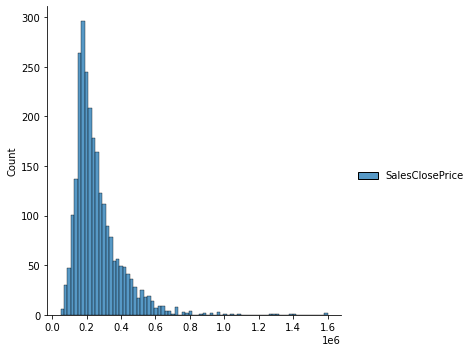

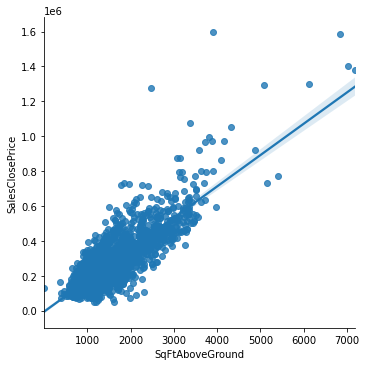

In [ ]:
import pyspark.sql.functions as F
import seaborn as sns
# We will use F.mean(col), F.skewness(col), F.min(col), F.cov(col1, col2), F.corr(col1, col2)

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Mean: เนื่องจาก mean เป็น aggregation จึงต้องใช้ .agg() method แล้วผ่าน dictionary ลงไป
df.agg({"SalesClosePrice": "mean"}).show()
df.agg({"SALESCLOSEPRICE": "mean"}).show() # ใช้ตัวใหญ่ตัวเล็ก PySpark ไม่สน

# Cov
df.cov("SalesClosePrice", "YearBuilt")

# พล็อตกราฟ ส่วนมากชอบเอา sample บางส่วนของข้อมูล แปลงเป็น Pandas ก่อน
# Sample 50% of Pyspark DataFrame
pdf = df.sample(withReplacement=False, fraction=0.5, seed=42).toPandas()

# Plotting distribution 
sample_df = df.select("SalesClosePrice").sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()
sns.displot(pandas_df)

# Relationship plotting
p_df = df.select("SalesClosePrice", "SqFtAboveGround").sample(False, 0.5, 42).toPandas()
sns.lmplot(x="SqFtAboveGround", y="SalesClosePrice", data=p_df)


In [ ]:
### Using corr()
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
df = df.withColumn('BACKONMARKETDATE', df['BACKONMARKETDATE'].cast("Double")) # ต้องเปลี่ยน
columns = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES', 'PDOM', 'SQFTABOVEGROUND', 'TAXES', 'TAXWITHASSESSMENTS', 'TAXYEAR', 'LIVINGAREA', 'YEARBUILT', 'ACRES', 'BACKONMARKETDATE', 'BATHSFULL', 'BATHSHALF', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'BATHSTOTAL', 'BEDROOMS', 'SQFTBELOWGROUND', 'ASSOCIATIONFEE', 'ASSESSEDVALUATION']
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for column in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr(column, 'SALESCLOSEPRICE')
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = column

print(corr_max_col)
print("It makes sense that homes with larger living areas would be correlated with more expensive homes.")

LIVINGAREA
It makes sense that homes with larger living areas would be correlated with more expensive homes.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


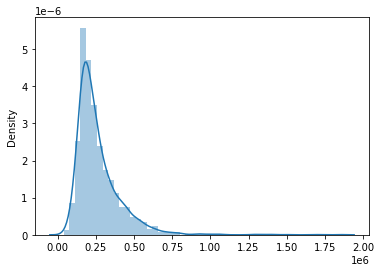

Skewness = 2.790448093916559


In [ ]:
# Using Visualizations: distplot
import matplotlib.pyplot as plt
import seaborn as sns

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(withReplacement=False, fraction=0.5, seed=42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(f'Skewness = {df.agg({"LISTPRICE": "skewness"}).collect()[0][0]}')

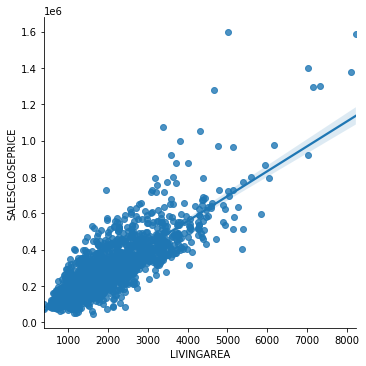

In [ ]:
# Using Visualizations: lmplot
import matplotlib.pyplot as plt
import seaborn as sns
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Select a the relevant columns and sample
sample_df = df.select(["SALESCLOSEPRICE", "LIVINGAREA"]).sample(withReplacement=False, fraction=0.5, seed=42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()


In [ ]:
# Drop irrelevant list of columns

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
cols_to_drop = ['No', 'UNITNUMBER', 'Class' ]

# ต้องใช้ * นำหน้า ในการ drop หลายๆคอลัมน์
df = df.drop(*cols_to_drop)

# .where, .filter
df.where(df["POTENTIALSHORTSALE"].like("Not Disclosed")).select('YEARBUILT', "POTENTIALSHORTSALE").show(5)
df.where(~df["POTENTIALSHORTSALE"].like("Not Disclosed")).select("YEARBUILT", "POTENTIALSHORTSALE").show(5)

# Filtering outliers
std_val = df.agg({"SalesClosePrice": "stddev"}).collect()[0][0]
mean_val= df.agg({"SalesClosePrice": "mean"}).collect()[0][0]
upper_bound = mean_val + (3 * std_val)
lower_bound = mean_val - (3 * std_val)

# Use .where() to filter the DataFrame between values
df.where((df["LISTPRICE"] < upper_bound ) & (df["LISTPRICE"] > lower_bound))

# Drop any row having nulls
df.dropna(how="any", thresh=None, subset=None)

# Drop rows having both LISTPRICE and SALESCLOSEPRICE as nulls
df.dropna(how="all", subset=["LISTPRICE", "SALESCLOSEPRICE"])

# Drop any rows having null values for at least 2 columns
df.dropna(thresh=2)

# Count the number of missing values in each column
print(df.where(df["ROOF"].isNull()).count())

# Drop dupllicates
df.dropDuplicates()

# Drop only subset of columns
df.dropDuplicates(["streetaddress"])



+---------+------------------+
|YEARBUILT|POTENTIALSHORTSALE|
+---------+------------------+
|     1954|     Not Disclosed|
|     1920|     Not Disclosed|
|     1955|     Not Disclosed|
|     1956|     Not Disclosed|
|     1909|     Not Disclosed|
+---------+------------------+
only showing top 5 rows

+---------+------------------+
|YEARBUILT|POTENTIALSHORTSALE|
+---------+------------------+
|     1950|                No|
|     1971|                No|
|     1949|                No|
|     1960|                No|
|     1978|                No|
+---------+------------------+
only showing top 5 rows

765


DataFrame[MLSID: string, StreetNumberNumeric: int, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, backonmarketdate: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string, RoomArea2: string, DiningRoo

In [ ]:
### MinMax Scaling
from pyspark.sql.functions import round
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

max_days = df.agg({"DAYSONMARKET": "max"}).collect()[0][0]
min_days = df.agg({"DAYSONMARKET": "min"}).collect()[0][0]
df.withColumn("scaled_days", (df["DAYSONMARKET"]-min_days)/(max_days - min_days))[["scaled_days"]].show(5)
df.withColumn("scaled_days_percent", round((df["DAYSONMARKET"]-min_days)/(max_days - min_days)*100))[["scaled_days_percent"]].show(5)


### Standardization 
mean_days = df.agg({"DAYSONMARKET": "mean"}).collect()[0][0]
stddev_days = df.agg({"DAYSONMARKET": "stddev"}).collect()[0][0]
df = df.withColumn("ztrans_days", (df["DAYSONMARKET"]-mean_days)/stddev_days)[["ztrans_days"]]
df.show(5)
print(f"The mean of 'ztrans_days' is {df.agg({'ztrans_days': 'mean'}).collect()[0][0]:.1f} and standard deviation is {df.agg({'ztrans_days': 'stddev'}).collect()[0][0]:.1f}")


+--------------------+
|         scaled_days|
+--------------------+
|0.044444444444444446|
|0.017777777777777778|
| 0.12444444444444444|
| 0.08444444444444445|
| 0.09333333333333334|
+--------------------+
only showing top 5 rows

+-------------------+
|scaled_days_percent|
+-------------------+
|                4.0|
|                2.0|
|               12.0|
|                8.0|
|                9.0|
+-------------------+
only showing top 5 rows

+--------------------+
|         ztrans_days|
+--------------------+
| -0.6394716073380993|
| -0.8484674699420623|
|-0.01248401952621...|
|-0.32597781343215465|
| -0.2563125258975003|
+--------------------+
only showing top 5 rows

The mean of 'ztrans_days' is -0.0 and standard deviation is 1.0


In [ ]:
  df.agg({'ztrans_days': 'stddev'}).collect()[0][0]

1.0000000000000009

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness = 2.790448093916559


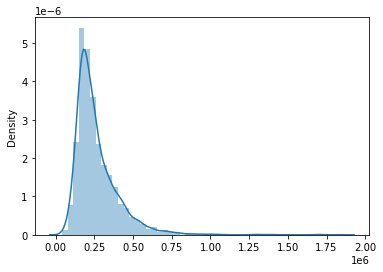

In [ ]:
### log scaling for right skewed data (positively skewed)

import matplotlib.pyplot as plt
import seaborn as sns

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE'])
pandas_df = sample_df.toPandas()
plt.show()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)


# Import skewness function
from pyspark.sql.functions import skewness, log

# Compute and print skewness of LISTPRICE
print(f'Skewness = {df.agg({"LISTPRICE": "skewness"}).collect()[0][0]}')



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


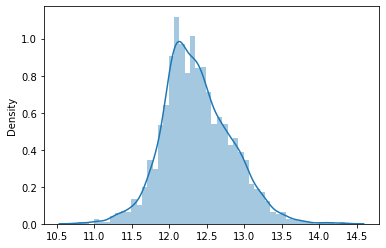

The skewness is 0.34790898624749833


In [ ]:
### Log Scaling (Cont)
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import skewness, log
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

df = df.withColumn("log_SalesClosePrice", log(df["SalesClosePrice"]))
sns.distplot(df.select("log_SalesClosePrice").toPandas())
plt.show()

print(f"The skewness is {df.agg({'log_SalesClosePrice': 'skewness'}).collect()[0][0]}")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


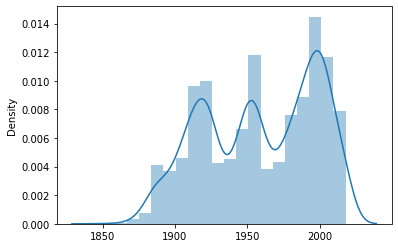

The skewness is -0.2455425013492729.


In [ ]:
### scaling for left skewed (negatively skewed data)
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import log, skewness
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
# Compute the skewness
sns.distplot(df.select("YEARBUILT").toPandas())
plt.show()
print(f"The skewness is {df.agg({'YEARBUILT': 'skewness'}).collect()[0][0]}.")



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


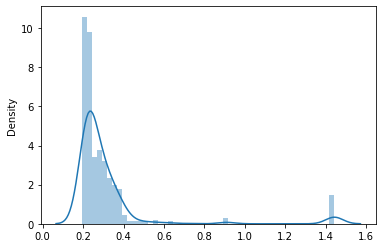

The skewness is 4.081397653256459.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import log, skewness

max_year = df.agg({'YEARBUILT': "max"}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))
sns.distplot(df[["adj_yearbuilt"]].toPandas())
plt.show()
print(f"The skewness is {df.agg({'adj_yearbuilt': 'skewness'}).collect()[0][0]}.")

# Not sure if this is worse.

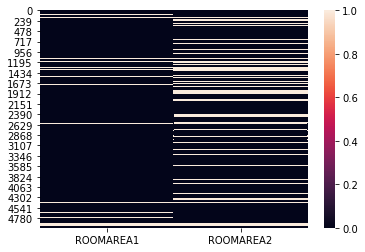

DataFrame[MLSID: string, StreetNumberNumeric: int, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, backonmarketdate: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string, RoomArea2: string, DiningRoo

In [ ]:
### Plotting missing values
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.select("ROOMAREA1", "ROOMAREA2").toPandas().isnull())
plt.show()

# Replace missing values with zero
df.fillna(0, subset=["DAYSONMARKET"])

# Replace missing values with means
df.fillna(df.agg({"DAYSONMARKET":"mean"}).collect()[0][0], subset=["DAYSONMARKET"])


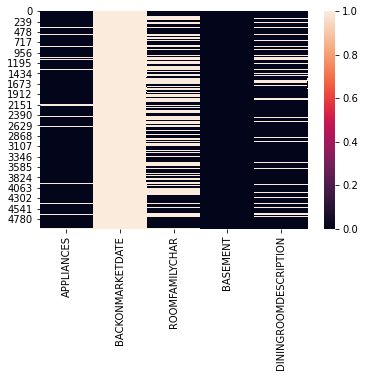

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import log, skewness
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
df = df.select(['APPLIANCES',  'BACKONMARKETDATE', 'ROOMFAMILYCHAR', 'BASEMENT', 'DININGROOMDESCRIPTION'])
sns.heatmap(df.toPandas().isnull())
plt.show()

In [ ]:
### Join DataFrame  

# No data available so don't run. 

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
walk_df = df.select(*['latitude', 'longitude', 'walkscore', 'bikescore', 'transitscore'])

# Cast data types
walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))
walk_df = walk_df.withColumn('latitude', walk_df['latitude'].cast('double'))

# Round precision
df = df.withColumn('longitude', round(df['longitude'], 5))
df = df.withColumn('latitude',  round(df['latitude'],  5))

# Create join condition
condition = [walk_df['latitude'] == df['latitude'], walk_df['longitude'] == df['longitude']]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')
# Count non-null records from new field
print(join_df.where(~join_df['walkscore'].isNull()).count())

### SQL joins
# Register dataframes as tables
df.createOrReplaceTempView('df')
walk_df.createOrReplaceTempView('walk_df')

# SQL to join dataframes
join_sql = 	"""
			SELECT 
				*
			FROM df
			LEFT JOIN walk_df
			ON df.longitude = walk_df.longitude
			AND df.latitude = walk_df.latitude
			"""
# Perform sql join
joined_df = spark.sql(join_sql)



In [ ]:
from pyspark.sql.functions import datediff, to_date
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
print("Types of date columns before converting.")
df[["OffMarketDate", "ListDate"]].show(5)
display(df[["OffMarketDate", "ListDate"]].printSchema())

# Convert string type to date type using to_date
df = df.withColumn("OffMarketDate", to_date(df["OffMarketDate"], 'M/d/y H:m'))
df = df.withColumn("ListDate", to_date(df["ListDate"], 'M/d/y H:m'))
print("Types of date columns after converting.")
df[["OffMarketDate", "ListDate"]].show(5)
display(df[["OffMarketDate", "ListDate"]].printSchema())

# Difference between dates
df = df.withColumn("calculated_days", datediff("OffMarketDate", "ListDate"))

# Notice some days on market are not consistent with calculated days.
df[["OffMarketDate", "ListDate", "calculated_days", "DAYSONMARKET"]].where("calculated_days = DAYSONMARKET").show(5)
df[["OffMarketDate", "ListDate", "calculated_days", "DAYSONMARKET"]].where("calculated_days != DAYSONMARKET").show(5)

Types of date columns before converting.
+---------------+--------------+
|  OffMarketDate|      ListDate|
+---------------+--------------+
| 7/30/2017 0:00|7/15/2017 0:00|
|10/13/2017 0:00|10/9/2017 0:00|
| 7/24/2017 0:00|6/26/2017 0:00|
| 9/13/2017 0:00|8/25/2017 0:00|
| 10/3/2017 0:00|9/12/2017 0:00|
+---------------+--------------+
only showing top 5 rows

root
 |-- OffMarketDate: string (nullable = true)
 |-- ListDate: string (nullable = true)



None

Types of date columns after converting.
+-------------+----------+
|OffMarketDate|  ListDate|
+-------------+----------+
|   2017-07-30|2017-07-15|
|   2017-10-13|2017-10-09|
|   2017-07-24|2017-06-26|
|   2017-09-13|2017-08-25|
|   2017-10-03|2017-09-12|
+-------------+----------+
only showing top 5 rows

root
 |-- OffMarketDate: date (nullable = true)
 |-- ListDate: date (nullable = true)



None

+-------------+----------+---------------+------------+
|OffMarketDate|  ListDate|calculated_days|DAYSONMARKET|
+-------------+----------+---------------+------------+
|   2017-10-13|2017-10-09|              4|           4|
|   2017-07-24|2017-06-26|             28|          28|
|   2017-09-13|2017-08-25|             19|          19|
|   2017-10-03|2017-09-12|             21|          21|
|   2017-04-27|2017-04-10|             17|          17|
+-------------+----------+---------------+------------+
only showing top 5 rows

+-------------+----------+---------------+------------+
|OffMarketDate|  ListDate|calculated_days|DAYSONMARKET|
+-------------+----------+---------------+------------+
|   2017-07-30|2017-07-15|             15|          10|
|   2017-11-11|2017-10-12|             30|          23|
|   2017-11-20|2017-09-02|             79|          73|
|   2017-06-11|2017-03-06|             97|           1|
|   2017-09-30|2017-06-26|             96|          40|
+-------------+--------

Corr of ACRES vs SALESCLOSEPRICE: 0.22060612588935327
Corr of LOT_SIZE_SQFT vs SALESCLOSEPRICE: 0.22060612588935338
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6152231695664401
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20714585430854263
+-----------------+---------+----------------+
|ASSESSEDVALUATION|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|              0.0|   139900|             0.0|
|              0.0|   210000|             0.0|
|              0.0|   225000|             0.0|
|              0.0|   230000|             0.0|
|              0.0|   239900|             0.0|
+-----------------+---------+----------------+
only showing top 5 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+---

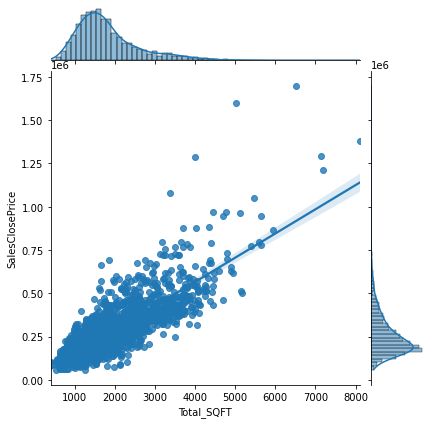

The R-squared for 'Total_SQFT' and 'SalesClosePrice' is 0.6692165500172175


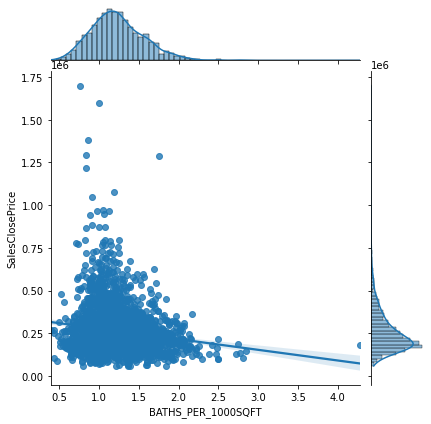

The R-squared for 'BATHS_PER_1000SQFT' and 'SalesClosePrice' is 0.022458203253482616
Note that the keyword argument 'stat_func' in Seaborn 0.11.1 is obsolete. 


In [ ]:
### Get more variables
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn("LOT_SIZE_SQFT", df["ACRES"] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn("YARD_SIZE", df["LOT_SIZE_SQFT"] - df["FOUNDATIONSIZE"])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr("ACRES", "SALESCLOSEPRICE")))
print("Corr of LOT_SIZE_SQFT vs SALESCLOSEPRICE: " + str(df.corr("LOT_SIZE_SQFT", "SALESCLOSEPRICE")))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr("FOUNDATIONSIZE", "SALESCLOSEPRICE")))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr("YARD_SIZE", "SALESCLOSEPRICE")))

# ASSESSED_TO_LIST
df = df.withColumn("ASSESSED_TO_LIST", df["ASSESSEDVALUATION"]/df["LISTPRICE"])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)
# TAX_TO_LIST
df = df.withColumn("TAX_TO_LIST", df["TAXES"]/ df["LISTPRICE"])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn("BED_TO_BATHS", df["BEDROOMS"]/df["BATHSTOTAL"])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

# Create new feature by adding two features together
df = df.withColumn("Total_SQFT", df["SQFTBELOWGROUND"] + df["SQFTABOVEGROUND"])

# Create additional new feature using previously created feature
df = df.withColumn("BATHS_PER_1000SQFT", df["BATHSTOTAL"] / (df["Total_SQFT"] / 1000))
df[["BATHS_PER_1000SQFT"]].describe().show()

# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots (Don't know what r2 is)
sns.jointplot(x="Total_SQFT", y="SalesClosePrice", data=pandas_df, kind="reg")#, stat_func=r2) stat_func is obsolete in sns 0.11
plt.show()
print(f"The R-squared for 'Total_SQFT' and 'SalesClosePrice' is {pandas_df[['Total_SQFT', 'SalesClosePrice']].corr().values[0, 1]**2}")
sns.jointplot(x="BATHS_PER_1000SQFT", y="SalesClosePrice", data=pandas_df, kind="reg")#, stat_func=r2)
plt.show()
print(f"The R-squared for 'BATHS_PER_1000SQFT' and 'SalesClosePrice' is {pandas_df[['BATHS_PER_1000SQFT', 'SalesClosePrice']].corr().values[0, 1]**2}")
print(f"Note that the keyword argument 'stat_func' in Seaborn {sns.__version__} is obsolete. ")

In [ ]:
### Datetime in PySpark
from pyspark.sql.functions import to_date, datediff, year, month, dayofmonth, weekofyear, lag, lead
from pyspark.sql.window import Window
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
print(df[["LISTDATE"]].dtypes)
df[["LISTDATE"]].show(5)

# Cast the data type to Date.
df = df.withColumn("LISTDATE", to_date("LISTDATE"))
print(df[["LISTDATE"]].dtypes)
df[["LISTDATE"]].show(5)
print("This doesn't work.  You must account for the date format.")

# Accounting for date format in to_date function.
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
df = df.withColumn("LISTDATE", to_date(df["LISTDATE"], 'M/d/y H:m'))
print(df[["LISTDATE"]].dtypes)
df[["LISTDATE"]].show(5)

# Create year and month columns
df = df.withColumn("LIST_YEAR", year("LISTDATE")).withColumn("LIST_MONTH", month("LISTDATE"))
df[["LISTDATE", "LIST_YEAR", "LIST_MONTH"]].show(5)
df = df.withColumn("LIST_DAYOFMONTH", dayofmonth("LISTDATE")).withColumn("LIST_WEEKOFYEAR", weekofyear("LISTDATE"))
df[["LISTDATE", "LIST_YEAR", "LIST_MONTH", "LIST_DAYOFMONTH", "LIST_WEEKOFYEAR"]].show(5)


#### INCOMPLETE ####

# Create window first
w = Window().orderBy(df["LISTDATE"])

# create lagged columns
print("Before order by date")
df[["LISTDATE", "SalesClosePrice"]].show(5)

print("After order by date")
df = df.withColumn("SalesClosePrice-ordered", lag("SalesClosePrice", offset=0).over(w)) 
df[["LISTDATE", "SalesClosePrice", "SalesClosePrice-ordered"]].show(5)
m_df = df.withColumn("SalesClosePrice-1wk", lag("SalesClosePrice", offset=7).over(w)) 
m_df[["LISTDATE", "SalesClosePrice-1wk", "SalesClosePrice"]].show()

[('LISTDATE', 'string')]
+--------------+
|      LISTDATE|
+--------------+
|7/15/2017 0:00|
|10/9/2017 0:00|
|6/26/2017 0:00|
|8/25/2017 0:00|
|9/12/2017 0:00|
+--------------+
only showing top 5 rows

[('LISTDATE', 'date')]
+--------+
|LISTDATE|
+--------+
|    null|
|    null|
|    null|
|    null|
|    null|
+--------+
only showing top 5 rows

This doesn't work.  You must account for the date format.
[('LISTDATE', 'date')]
+----------+
|  LISTDATE|
+----------+
|2017-07-15|
|2017-10-09|
|2017-06-26|
|2017-08-25|
|2017-09-12|
+----------+
only showing top 5 rows

+----------+---------+----------+
|  LISTDATE|LIST_YEAR|LIST_MONTH|
+----------+---------+----------+
|2017-07-15|     2017|         7|
|2017-10-09|     2017|        10|
|2017-06-26|     2017|         6|
|2017-08-25|     2017|         8|
|2017-09-12|     2017|         9|
+----------+---------+----------+
only showing top 5 rows

+----------+---------+----------+---------------+---------------+
|  LISTDATE|LIST_YEAR|LIST_MON

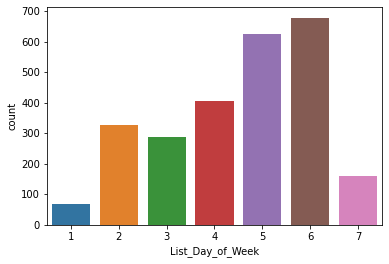

In [ ]:
### Example of datetime

# Import needed functions
from pyspark.sql.functions import to_date, dayofweek
import matplotlib.pyplot as plt
import seaborn as sns

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Convert to date type
df = df.withColumn("LISTDATE", to_date("LISTDATE", 'M/d/y H:m'))

# Get the day of the week
df = df.withColumn("List_Day_of_Week", dayofweek("LISTDATE"))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

In [ ]:
#### Extracting features

from pyspark.sql.functions import when, split

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
df[["ROOF"]].show(5, truncate=False)
find_under_8 = df["ROOF"].like("%Age 8 Years or Less%") # เครื่องหมาย % แปลว่ามีอะไรก็ได้
find_over_8 = df["ROOF"].like("%Age Over 8 Years%")

# Using when and otherwise
df = df.withColumn("old_roof", when(find_over_8, 1).when(find_under_8, 0).otherwise(None))
df[["old_roof", "roof"]].show(5, truncate=False)

# Using split
df = df.withColumn("Roof_Material", split("ROOF", ",").getItem(0))[["ROOF", "Roof_Material"]].show(5, truncate=False)

+----------------------------------------------+
|ROOF                                          |
+----------------------------------------------+
|null                                          |
|Asphalt Shingles, Pitched, Age 8 Years or Less|
|null                                          |
|Asphalt Shingles, Pitched, Age 8 Years or Less|
|Asphalt Shingles, Age Over 8 Years            |
+----------------------------------------------+
only showing top 5 rows

+--------+----------------------------------------------+
|old_roof|roof                                          |
+--------+----------------------------------------------+
|null    |null                                          |
|0       |Asphalt Shingles, Pitched, Age 8 Years or Less|
|null    |null                                          |
|0       |Asphalt Shingles, Pitched, Age 8 Years or Less|
|1       |Asphalt Shingles, Age Over 8 Years            |
+--------+----------------------------------------------+
only showing

In [ ]:
#### Extracting features: Explode and Pivot

from pyspark.sql.functions import when, split, explode,lit, coalesce, first
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Split the columns on commas into a list
df = df.withColumn("roof_list", split("ROOF", ","))
df[["No", "ROOF", "roof_list"]].show(5, truncate=False)

# Explode the list into  new records for each value หลักการคล้าย melt
print("Explode the list into  new records for each value หลักการคล้าย melt")
ex_df = df.withColumn("ex_roof_list", explode("roof_list"))
ex_df[["No", "roof_list", "ex_roof_list"]].show(10, truncate=False)
ex_df[["ex_roof_list"]].distinct().show(30, truncate=False)

# Create a dummy column of constant value
ex_df = ex_df.withColumn("constant_val", lit(1))
ex_df[["No", "roof_list", "ex_roof_list", "constant_val"]].show(10, truncate=False)

# Pivot the values in 'ex_roof_list' into boolean columns
# groupby No ได้เพราะมีก็อปปี้ของ No เกิดขึ้นจาก explode
piv_df = ex_df.groupBy("No").pivot("ex_roof_list").agg(coalesce(first("constant_val")))
piv_df.show(10, truncate=False)

# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO', how="left")

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)
zfilled_df.show(truncate=False)

+---+----------------------------------------------+--------------------------------------------------+
|No |ROOF                                          |roof_list                                         |
+---+----------------------------------------------+--------------------------------------------------+
|1  |null                                          |null                                              |
|2  |Asphalt Shingles, Pitched, Age 8 Years or Less|[Asphalt Shingles,  Pitched,  Age 8 Years or Less]|
|3  |null                                          |null                                              |
|4  |Asphalt Shingles, Pitched, Age 8 Years or Less|[Asphalt Shingles,  Pitched,  Age 8 Years or Less]|
|5  |Asphalt Shingles, Age Over 8 Years            |[Asphalt Shingles,  Age Over 8 Years]             |
+---+----------------------------------------------+--------------------------------------------------+
only showing top 5 rows

Explode the list into  new records for 

In [ ]:
### Binarizing สร้างตัวแปร 0, 1
from pyspark.ml.feature import Binarizer
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
print(df[["FIREPLACES"]].dtypes)

# Data type must be double
df = df.withColumn("FIREPLACES", df["FIREPLACES"].cast("double"))
print(df[["FIREPLACES"]].dtypes)

# Create binarizing transformer
bin = Binarizer(threshold=0.0, inputCol="FIREPLACES", outputCol="FireplaceT")

# Apply the transformer ค่าที่มากกว่า 0 จะแปลงเป็น 1 ให้หมด
df = bin.transform(df)
df[["FIREPLACES", "FireplaceT"]].where("FIREPLACES > 1").show(5)
df[["FIREPLACES", "FireplaceT"]].show(5)

[('FIREPLACES', 'int')]
[('FIREPLACES', 'double')]
+----------+----------+
|FIREPLACES|FireplaceT|
+----------+----------+
|       2.0|       1.0|
|       2.0|       1.0|
|       2.0|       1.0|
|       2.0|       1.0|
|       2.0|       1.0|
+----------+----------+
only showing top 5 rows

+----------+----------+
|FIREPLACES|FireplaceT|
+----------+----------+
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       1.0|       1.0|
|       1.0|       1.0|
+----------+----------+
only showing top 5 rows



In [ ]:
### Bucketing สร้างตัวแปร ordinal
from pyspark.ml.feature import Bucketizer
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
print(df[['BATHSTOTAL']].dtypes)
df[['BATHSTOTAL']].show(5)
splits = [0, 1, 2, 3, 4, float('Inf')]

# Create bucketing transformer
buck = Bucketizer(splits=splits, inputCol='BATHSTOTAL', outputCol='baths')

# Apply transformer
df = buck.transform(df)
print(df[['BATHSTOTAL', 'baths']].dtypes)
df[['BATHSTOTAL', 'baths']].distinct().show(5)

[('BATHSTOTAL', 'int')]
+----------+
|BATHSTOTAL|
+----------+
|         2|
|         3|
|         1|
|         2|
|         2|
+----------+
only showing top 5 rows

[('BATHSTOTAL', 'int'), ('baths', 'double')]
+----------+-----+
|BATHSTOTAL|baths|
+----------+-----+
|         6|  4.0|
|         5|  4.0|
|         4|  4.0|
|         3|  3.0|
|         2|  2.0|
+----------+-----+
only showing top 5 rows



In [40]:
### One Hot Encoder
from pyspark.ml.feature import OneHotEncoder, StringIndexer
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
print(df[["CITY"]].dtypes)
df[["CITY"]].distinct().show(5)

# Create string indexer
stringIndexer = StringIndexer(inputCol='City', outputCol='City_Index')

# Fit transformer
model = stringIndexer.fit(df)

# Apply transformer
indexed = model.transform(df)
indexed[["City", "City_Index"]].distinct().show(5)

# Create encoder
encoder = OneHotEncoder(inputCol="City_Index", outputCol="City_Vec")
encoded_df = encoder.fit(indexed).transform(indexed)
encoded_df[["City", "City_Vec"]].distinct().show(5)
encoded_df[["City_Vec"]].distinct().rdd.take(5)

[('CITY', 'string')]
+----------------+
|            CITY|
+----------------+
|  OAKD - Oakdale|
|MAPW - Maplewood|
|   WB - Woodbury|
|LELM - Lake Elmo|
|STP - Saint Paul|
+----------------+

+----------------+----------+
|            City|City_Index|
+----------------+----------+
|MAPW - Maplewood|       2.0|
|  OAKD - Oakdale|       3.0|
|LELM - Lake Elmo|       4.0|
|   WB - Woodbury|       1.0|
|STP - Saint Paul|       0.0|
+----------------+----------+

+----------------+-------------+
|            City|     City_Vec|
+----------------+-------------+
|LELM - Lake Elmo|    (4,[],[])|
|STP - Saint Paul|(4,[0],[1.0])|
|  OAKD - Oakdale|(4,[3],[1.0])|
|MAPW - Maplewood|(4,[2],[1.0])|
|   WB - Woodbury|(4,[1],[1.0])|
+----------------+-------------+



[Row(City_Vec=SparseVector(4, {2: 1.0})),
 Row(City_Vec=SparseVector(4, {0: 1.0})),
 Row(City_Vec=SparseVector(4, {})),
 Row(City_Vec=SparseVector(4, {3: 1.0})),
 Row(City_Vec=SparseVector(4, {1: 1.0}))]

In [3]:
### Test and Train Splits for Time Series.  
# Splitting data randomly can be dangerous for time series as data from the future can cause overfitting in our model.
# Create variables for max and min dates
from pyspark.sql.functions import to_date, datediff, lit, date_add, round
import numpy as np
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
df = df.withColumn("offmarketdate", to_date(df["offmarketdate"], 'M/d/y H:m'))
df = df.withColumn("LISTDATE", to_date(df["LISTDATE"], 'M/d/y H:m'))
max_date = df.agg({"offmarketdate": "max"}).collect()[0][0]
min_date = df.agg({"offmarketdate": "min"}).collect()[0][0]

# the line range_in_days = datediff(max_date, min_date) just doesn't work.
# This instructor is by far the worst in Pyspark route.
range_in_days = df.withColumn("TEST", datediff(lit(max_date), lit(min_date)))[["TEST"]].rdd.first()[0]
split_in_days = int(range_in_days * 0.8)
split_date = df.withColumn("TEST1", date_add(lit(min_date), split_in_days))[["TEST1"]].rdd.first()[0]

# Split the data by date
train_df = df.where(df["offmarketdate"] < split_date)
test_df = df.where(df["offmarketdate"] >= split_date).where(df["LISTDATE"] >= split_date)
train_df[["offmarketdate"]].show(5)
test_df[["offmarketdate", "LISTDATE"]].show(5)

+-------------+
|offmarketdate|
+-------------+
|   2017-07-30|
|   2017-10-13|
|   2017-07-24|
|   2017-09-13|
|   2017-10-03|
+-------------+
only showing top 5 rows

+-------------+----------+
|offmarketdate|  LISTDATE|
+-------------+----------+
|   2017-12-15|2017-12-15|
|   2017-12-12|2017-12-12|
|   2017-12-15|2017-12-15|
|   2017-12-03|2017-12-03|
|   2017-12-29|2017-12-29|
+-------------+----------+
only showing top 5 rows



In [18]:
### Random Forest
# Perform value replacement for missing values and encode categorical text features to numeric.
# The dataset provided has not been converted to numeric.
# Dropping columns with less than 30 observations is recommended.

from pyspark.ml.feature import VectorAssembler
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Random Forest usually fillna with -1
df = df.fillna(-1)
features_cols = df.columns

# Remove the dependent variables so that the dataframe contains only features
features_cols.remove("SalesClosePrice")

# Create VectorAssembler
vec = VectorAssembler(inputCols=features_cols, outputCol='features')

# Apply the vector transformer to the data

# This doesn't work as expected from this instructor!
# Perform value replacement for missing values and encode categorical text features to numeric.
# This means he has already modified his df.
df = vec.transform(df)


AttributeError: ignored

In [27]:
### Naively Handling Missing and Categorical Values
# The dataset doesn't have 'walkscore' and 'bikescore' so we cannot 100% replicate.
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

categorical_cols = ['CITY',  'LISTTYPE', 'SCHOOLDISTRICTNUMBER', 'POTENTIALSHORTSALE', 'STYLE', 'ASSUMABLEMORTGAGE', 'ASSESSMENTPENDING']

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)
df = df.select(['CITY', 'LISTTYPE', 'SCHOOLDISTRICTNUMBER', 'POTENTIALSHORTSALE', 'STYLE', 'ASSUMABLEMORTGAGE', 'ASSESSMENTPENDING'])
print(df.dtypes)

# Replace missing values
df = df.fillna(-1)#, subset=["WALKSCORE", "BIKESCORE"])

indexers = [StringIndexer(inputCol=col, outputCol=col+"_IDX").setHandleInvalid("keep") for col in categorical_cols]
# Create pipeline of indexers
indexer_pipeline = Pipeline(stages=indexers)
# Fit and Transform the pipeline to the original data
df_indexed = indexer_pipeline.fit(df).transform(df)

# Clean up redundant columns
df_indexed = df_indexed.drop(*categorical_cols)
# Inspect data transformations
print(df_indexed.dtypes)

df_indexed.show(5, truncate=False)

[('CITY', 'string'), ('LISTTYPE', 'string'), ('SCHOOLDISTRICTNUMBER', 'string'), ('POTENTIALSHORTSALE', 'string'), ('STYLE', 'string'), ('ASSUMABLEMORTGAGE', 'string'), ('ASSESSMENTPENDING', 'string')]
[('CITY_IDX', 'double'), ('LISTTYPE_IDX', 'double'), ('SCHOOLDISTRICTNUMBER_IDX', 'double'), ('POTENTIALSHORTSALE_IDX', 'double'), ('STYLE_IDX', 'double'), ('ASSUMABLEMORTGAGE_IDX', 'double'), ('ASSESSMENTPENDING_IDX', 'double')]
+--------+------------+------------------------+----------------------+---------+---------------------+---------------------+
|CITY_IDX|LISTTYPE_IDX|SCHOOLDISTRICTNUMBER_IDX|POTENTIALSHORTSALE_IDX|STYLE_IDX|ASSUMABLEMORTGAGE_IDX|ASSESSMENTPENDING_IDX|
+--------+------------+------------------------+----------------------+---------+---------------------+---------------------+
|4.0     |0.0         |3.0                     |0.0                   |2.0      |4.0                  |1.0                  |
|4.0     |0.0         |3.0                     |0.0             

In [4]:
### Random Forest Model
# No actual data available.  Don't run!

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# Initialize 
rf = RandomForestRegressor(featuresCol="features", labelCol="SalesClosePrice", predictionCol="Prediction_Price", seed=42)

# Train Model
model = rf.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

# select columns to compute error
evaluator = RegressionEvaluator(labelCol="SalesClosePrice", predictionCol="Prediction_Price")

# Create evaluation metrics
RMSE = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})  # มีหน่วยเดียวกันกับ SalesClosePrice
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})




In [11]:
### Intepreting model
import pandas as pd
from pyspark.ml.regression import RandomForestRegressionModel
# Convert important features to a pandas column
fi_df = pd.DataFrame(model.featureImportance.toArray(), columns=["importance"])

# Convert list of feature names to pandas columns
fi_df["feature"] = pd.Series(feature_cols)

# Sort the data based on feature importance
fi_df.sort_values(by=["importance"], ascending=False, inplace=True)

# Interpret result
# ไอ้ห่า แล้ว model_df มันมาจากไหนวะ ?!
model_df.head()

# Save model
model.save("rfr_real_estate_model")

# Load model
model2 = RandomForestModel.load("rfr_real_estate_model")


'3.0.1'

In [13]:
spark.version

'3.0.1'